Alexander S. Lundervold, October 17th, 2020

See also Geron's notebook: https://github.com/ageron/handson-ml2/blob/master/07_ensemble_learning_and_random_forests.ipynb

# Introduction

Random forests are **ensembles** of decision trees. As we've seen, a single decision tree is typically very sensitive to small changes in the training data and they tend to overfit. However, by constructing multiple decision trees in a particular way, and then combine them to make predictions, these problems are mitigated. As well as being less sensitive and less prone to overfitting, the resulting models, called **random forests**, have much higher performance. 

Ensembling techniques are related to the concept of the <a href="https://en.wikipedia.org/wiki/Wisdom_of_the_crowd">wisdom of the crowd</a>. In many situations, a crowd of non-expert that combine their predictions outperform individual experts. 

The idea is not new, of course. Here's Aristotle pointing this out back in 350 B.C.E:
> *For the many, of whom each individual is but an ordinary person, when they meet together may very likely be better than the few good, if regarded not individually but collectively, just as a feast to which many contribute is better than a dinner provided out of a single purse* <br>&ndash; Aristotle, <a href="http://classics.mit.edu/Aristotle/politics.3.three.html">Politics Book III</a>

*Ensembling* is a general technique for combining machine learning models to make even more powerful models. 

There are several variants of this, as we'll see. **Voting**, **bagging**, **boosting**, **stacking**. We'll meet these concepts as we go along, but *we won't go into detail on ensembling in general, but rather focus on random forests and gradient boosting*. 

>**You should read through chapter 7 of the textbook to get a broader understanding of ensembling**. We'll look at some highlights in the lecture.

Two very powerful and widely used models made using ensembling are **random forests**, based on bagging, and **gradient boosted decision trees**, based on boosting. 

# Setup

In [1]:
# To automatically reload modules defined in external files.
%reload_ext autoreload
%autoreload 2

# To display plots directly in the notebook:
%matplotlib inline

In [2]:
from pathlib import Path 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import sklearn
from sklearn.model_selection import train_test_split

import seaborn as sns # For nicer plots

In [3]:
# To make the notebook reproducible
seed = 42
np.random.seed(seed)

# Random forests

As we've seen, single decision trees tend to be very sensitive to the exact training data it's fed, and also tend to overfit. 

By training multiple decision trees on different parts of the training data, each one may overfit and be very sensitive, but by *averaging* their predictions the sensitivity is reduced and the overfitting combatted. 

Let's say we want to build 500 trees on a training set containing `n_samples` point. Each tree is built in the following way:

1. Each tree trained on different data sets: Choose one data point at random for the training data, **with replacement**. Do this `n_samples` times, that is, until you have `n_samples` points. This is called **bootstrap sampling**.  
2. Each tree trained on different features: Train a decision tree on this data set, but at each node of the tree **select a random set of features to consider when splitting**, up to `max_features` of them.  

This is a random forest.

Predictions from a random forest is done differently for regression and classification: 

- **Regression:** Let each tree make a prediction, then average them.
- **Classification:** Let each tree make a prediction, and use a **soft voting strategy** to combine them. As we saw in the decision trees notebook, each tree provides a probability for its prediction. Average these probabilites and predict the class that has the highest average probability. 

In [4]:
import IPython
IPython.display.Image("assets/rf_datacamp.PNG", width='70%')

FileNotFoundError: No such file or directory: 'assets/rf_datacamp.PNG'

FileNotFoundError: No such file or directory: 'assets/rf_datacamp.PNG'

<IPython.core.display.Image object>

<center><small>Picture from <a href="http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1526467744/voting_dnjweq.jpg">here</a></center>

## An important exercise:

> **Your turn!** When you find the time it's highly recommended that you work through exercise 8 in Chapter 6 of the textbook. Here you'll essentially construct and train a random forest model yourself. The notebook will be updated with a possible solution later. **Please attempt the exercise yourself before looking at the suggested solution.**

## Two simple examples of using random forests

Let's try it out on the two data sets studied in the notebook on decision trees: the **diabetes data set** (classification) and the **Boston housing data** set (regression).

The notebook `DAT158-Part2-6-Extra-RandomForests-Examples.ipynb` will go through a number of additional examples. 

### Classification: the diabetes data set

In [5]:
datadir = Path("./data")
diabetes_data = pd.read_csv(datadir/'diabetes.csv')
diabetes_data.head()

,pregnancies,glucose,diastolic,triceps,insulin,bmi,dpf,age,diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [6]:
X = diabetes_data.drop('diabetes', axis=1)
y = diabetes_data['diabetes']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=seed)

In [8]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=seed)

In [9]:
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Random forests have some hyperparameters, mostly inherited from those for decision trees:

In [10]:
rf_clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

The most important ones when using random forests in practice are:
* the parameters acting as regularization for the decision trees discussed in the previous notebook (`DAT158-Part2-4-Decision_Trees.ipynb`): i.e. `max_depth` (arguably the most important one, and often the only regularization set to non-default values), `max_features`, `min_samples_split`, `min_samples_leaf`, `max_leaf_nodes`, `min_impurity_decrease`, `min_weight_fraction_leaf`.
* `n_estimators`: the number of decision trees in the forest. Increase to get increased model expressiveness. 
* `n_jobs`: set to `-1` to use all available CPUs. Useful when training random forests on large data sets.

Let's test the trained model on the test set:

In [11]:
rf_clf.score(X_test, y_test)

0.75

### Regression: the Boston housing data set

In [12]:
from sklearn.tree import DecisionTreeRegressor

In [13]:
from sklearn.datasets import load_boston

In [14]:
boston = load_boston()

In [15]:
X = boston['data']
y = boston['target']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)

In [17]:
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor(random_state=seed)

In [18]:
rf_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [20]:
y_pred = rf_reg.predict(X_test)

In [21]:
mean_squared_error(y_test, y_pred)

10.374371921259836

In [22]:
mean_absolute_error(y_test, y_pred)

2.1481259842519673

#### The California housing data set

Let's try it on another housing data set:

In [23]:
from sklearn.datasets import fetch_california_housing

In [24]:
housing = fetch_california_housing(data_home='./data')

In [25]:
X = pd.DataFrame(data=housing.data, columns=housing.feature_names)
y = housing.target

In [26]:
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)

In [28]:
rf_reg = RandomForestRegressor(random_state=seed, n_jobs=-1)
rf_reg.fit(X_train, y_train)
print(mean_squared_error(y_test, rf_reg.predict(X_test)))

0.25426675239626045


# Boosting

> Producing strong learners from an ensemble of weak learners

## Introduction

Another widely used and powerful class of tree-based machine learning models are those based on **boosted trees**. With this tool added to you toolbelt you're well-equipped to face most machine learning modelling tasks you'll meet in real life.

We've learned that random forests are ensembles of decision trees, making predictions by simply averaging all the models in the ensemble. **Boosting** takes another approach to ensembling: new members are added to the ensemble _sequentially_, each new model is trained on the _errors_ of the ensemble constructed so far, iteratively learning from its mistakes. We'll focus on boosting based on decision trees, as these are the most common base-models.

One of the main boosting techniques is **AdaBoost**. Here each additional tree focuses on the examples (i.e. _instances_) that were misclassified by the previous trees. 

In **gradient boosting**, each tree added to the ensemble tries to predict the *residual error* from the previously added tree. In other words, it's trained to predict the difference between the correct value and the value predicted from the ensemble so far. 

Each individual tree is what's called a **weak learner**, not able to fit the data very well. But by combining them by having each tree try to predict the residual of the previous trees' predictions, the result is a very **strong learner**. In fact, we can end up with some of the strongest learnes we know. 

See Geron's notebook here: https://github.com/ageron/handson-ml2/blob/master/07_ensemble_learning_and_random_forests.ipynb

More details about gradient boosting can be found [here](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/) or [here]() (we will base our discussion partly on the one in the first link).

## AdaBoost: Adaptive boosting

AdaBoost was introduced in 1995 ([here](https://www.sciencedirect.com/science/article/pii/S002200009791504X)) and was the first boosting algorithm that had practical use cases. It won the authors the 2003 Gödel Prize for outstanding journal article in theoretical computer science because of the algorithm's _"elegance, simplicity of implementation, its wide applicability, and its striking success in reducing errors in benchmark applications even while its theoretical assumptions are not known to hold"_. 

AdaBoost _"set off an explosion of research in the fields of statistics, artificial intelligence, experimental machine learning, and data mining"_ ([source](http://eatcs.org/index.php/component/content/article/505)).

The basic idea is relatively simple: 

- Give each instance in the training data an _instance weight_, initally set to 1/m where m is the number of instances.
- Extract a sample of the training data and train a *weak learner* on it. The weak learners in AdaBoost are typically decision trees of depth 1 (so-called *decision stumps*), but other models can be used. 
- Calculate a weight for the learner, based on its error rate. Higher accuracy means higher weight.
- Then increase the weight of the misclassified instances according to the learner's weight. An instance misclassified by a high-weight learner gets higher weight than one misclassified by a low weight learner.
- Extract another sample from the training data, sampled according to the instance weights. 
- Train the next weak learner on the sampled data, compute the learner weight and update the weights of the training instances accordingly. 
- Continue until perfect fit or `n_estimators` have been trained. 

Each new learner added to the ensemble corrects the shortcomings of previous models as it focuses on high-weight instances. In other words, the weighing of the training data makes the new learner focus more on difficult cases.

Predictions from AdaBoost are made by producing predictions from all the weak learners, weighted according to their weights.

<img width=50% src="assets/adaboost.png">

### AdaBoost in more detail

To make the above procedure a bit clearer, here are the steps for classificatio using AdaBoost in more detail:

At the start we don't know which instances are most difficult so we give them the same weight, making sure that the sum of all weights is 1: set the weights of all $m$ instances to $w^{(i)} = 1/m$ (note that the sum of all instance weights is 1).

1. Train a weak learner on a sample of the training data
2. Get the error rate of the learner on the sample:

$$r_i = \frac{\mbox{sum of weights of errors}}{\mbox{sum of errors}} = \frac{\underset{\hat{y}_j^{(i)} \neq y_j}{\sum w^{(i)}}}{\sum w^{(i)}}$$

3. Compute the learner's weight:

$$\alpha_j = \eta \log \frac{1-r_j}{r_j},$$ where $\eta$ is the learning rate. (See below for an explanation of the formula.)

4. Update all the weights of the misclassified instances:

$$\mbox{For  } \hat{y}_j^{(i)} \neq y^{(i)}: \quad w^{(i)} := w^{(i)} \exp(\alpha_j),$$

and normalize them to keep the sum equal to 1: $$w^{(i)} := \frac{w^{(i)}}{\sum w^{(i)}}.$$

Repeat 1-4.

##### **A closer look at the learner weights:**

In [29]:
# The error rate of a learner is between 0 and 1
r = np.arange(0.001, 1, 0.01) 

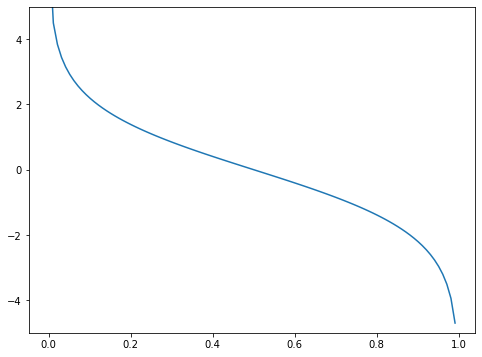

In [30]:
# The formula for the learner weights
learning_rate = 1

plt.figure(figsize=(8,6))
plt.plot(r, learning_rate*np.log((1-r)/r))
plt.ylim([-5,5])
plt.show()

> Higher error rate means lower learner weight.

### In scikit-learn

Let's try it out on the California Housing data provided by scikit-learn:

In [31]:
housing = fetch_california_housing(data_home='./data')

In [32]:
X = pd.DataFrame(data=housing.data, columns=housing.feature_names)
y = housing.target

In [33]:
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)

In [35]:
from sklearn.metrics import mean_squared_error

In [36]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

Let's first try a single decision stump (our weak learner):

In [37]:
dt_reg = DecisionTreeRegressor(max_depth=1, random_state=seed)
dt_reg.fit(X_train, y_train)
mean_squared_error(y_test, dt_reg.predict(X_test))

0.9358890477080715

..then an AdaBoost ensemble of 10 decision stumps:

In [38]:
ada_reg = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=1), 
                             n_estimators=10, random_state=seed)

In [39]:
ada_reg.fit(X_train, y_train)
mean_squared_error(y_test, ada_reg.predict(X_test))

0.8355015981506355

Significantly better!

**Note:** this was an unusually simple AdaBoostRegressor, just for demonstration and comparison with decision trees. Here's a more reasonable model:

In [40]:
ada_reg = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=None),
                           n_estimators=50, random_state=seed)
ada_reg.fit(X_train, y_train)
mean_squared_error(y_test, ada_reg.predict(X_test))

0.24289830572379842

## Gradient boosting: gradient descent + boosting

In AdaBoost the learners added to the ensemble tries to correct its predecessors by changing the weights on the data points. Gradient boosting has the same objective, but rather than tweaking the instance weights, each new learner attempts to predict the _residual error_ of the ensemble.

### Residual errors: the basic idea behind gradient boosting

We'll try to build such a boosting ensemble ourselves. First we'll explain it in a spreadsheet, then in code. Gradient boosting builds on this, as we shall see.

#### Residual errors and boosting using a spreadsheet

> Go to http://bit.ly/boosting_example for boosting explained in a spreadsheet. We'll go through it in the lecture.

#### Residual errors and boosting using scikit-learn

Let's use the randomly generated data as in the textbook (see Chapter 7).

In [41]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

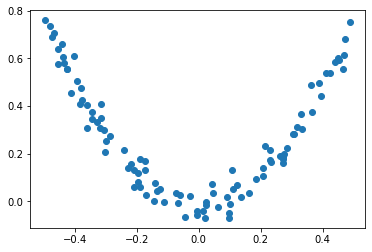

In [42]:
plt.scatter(X,y)
plt.show()

We also need some new data on which to make predictions:

In [43]:
X_new = np.linspace(-0.5, 0.5, 500)
X_new = X_new.reshape(-1, 1)

Our initial model will be the mean value of the target (as that is the value minimizing mean squared error):

In [44]:
from sklearn.dummy import DummyRegressor

In [45]:
F_0 = DummyRegressor(strategy='mean')

In [46]:
F_0.fit(X, y)

DummyRegressor()

This is our initial model and our goal is to improve it.

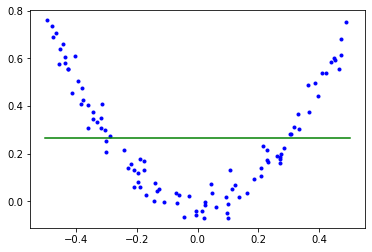

In [47]:
fig, ax = plt.subplots()
ax.plot(X[:, 0], y, 'b.')
ax.plot(X_new, F_0.predict(X_new), 'g-')
plt.show()

Next we'll train a single decision tree on the residuals of the initial model:

In [48]:
y_0 = y - F_0.predict(X)

In [49]:
from sklearn.tree import DecisionTreeRegressor
h_0 = DecisionTreeRegressor(max_depth=2)
h_0.fit(X,y_0)

DecisionTreeRegressor(max_depth=2)

Our first ensemble is now simply the sum of $F_0$ and $h_0$: $$F_1 = F_0 + h_0$$

We take a look at its predictions on some new data:

In [50]:
# A convenience function for plotting predictions of our ensembles
def plot_predictions(models):
    y_pred = sum(model.predict(X_new) for model in models)
    fig, ax = plt.subplots()
    ax.plot(X[:, 0], y, 'b.')
    ax.plot(X_new, y_pred, 'g-')
    plt.show()

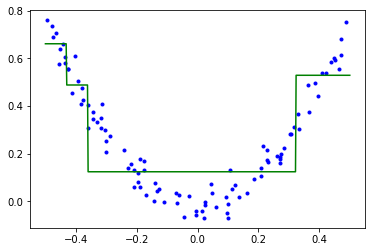

In [51]:
plot_predictions([F_0, h_0])

A big improvement!

Let's make a larger ensemble:

In [52]:
# Residuals from previous ensemble
F_1_pred = F_0.predict(X) + h_0.predict(X) 
y1 = y - F_1_pred

In [53]:
# Model fitted to the residuals:
h_1 = DecisionTreeRegressor(max_depth=2)
h_1.fit(X,y1)

DecisionTreeRegressor(max_depth=2)

In [54]:
# Updated ensemble:
F_2_pred = F_1_pred + h_1.predict(X)

In [55]:
# Residuals:
y2 = y - F_2_pred

In [56]:
# Model fitted to the residuals:
h_2 = DecisionTreeRegressor(max_depth=2)
h_2.fit(X, y2)

DecisionTreeRegressor(max_depth=2)

In [57]:
# Updated ensemble:
F_3_pred = F_2_pred + h_2.predict(X)

Here are the initial ensemble results:

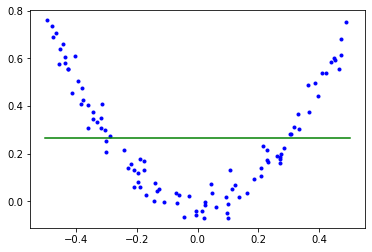

In [58]:
plot_predictions([F_0,])

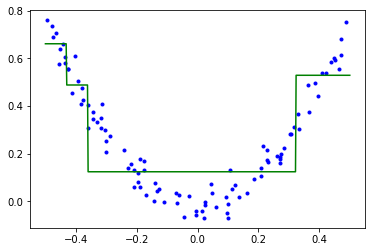

In [59]:
plot_predictions([F_0, h_0])

After adding a second model:

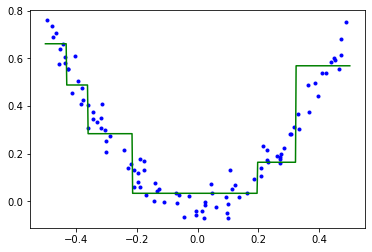

In [60]:
plot_predictions([F_0, h_0, h_1])

After adding another model:

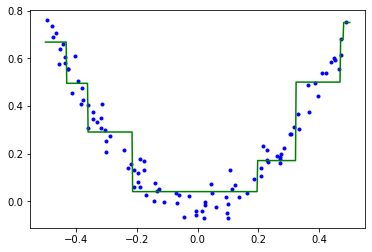

In [61]:
plot_predictions([F_0, h_0, h_1, h_2])

**Magic!**

We can continue this for as long as we want:

In [62]:
def boosting(k=3, X=X, y=y):
    """
    Trains k trees on the randomly generated points
    """

    # Construct models
    models = []
    
    ## Initial model:
    F_0 = DummyRegressor(strategy='mean')
    F_0.fit(X,y)
    y = y - F_0.predict(X)
    models.append(F_0)
    
    ## Creating the ensemble
    for i in range(k):
        h = DecisionTreeRegressor(max_depth=2)
        h.fit(X,y)
        models.append(h)
        y = y - h.predict(X)
    
    plot_predictions(models)

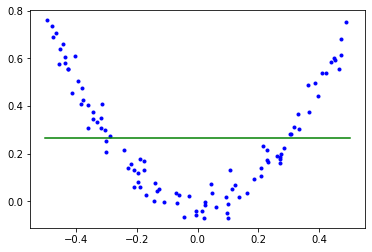

In [63]:
boosting(k=0)

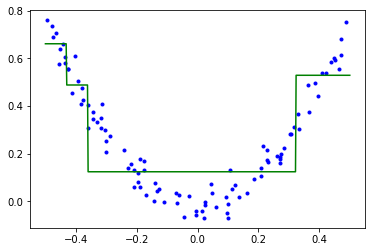

In [64]:
boosting(k=1)

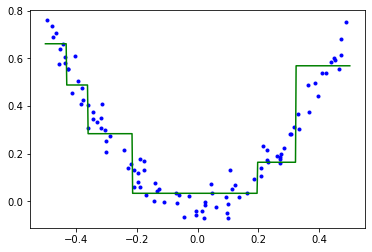

In [65]:
boosting(k=2)

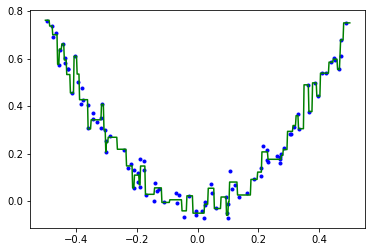

In [66]:
boosting(k=30)

#### Residual errors and the boosting algorithm:

The above recursive procedure can be described as follows:

* Create an initial model, $F_0$
* Fit a model to the residuals, $h_0(x) \sim y - F_0(x)$
* Create an ensemble, $F_1(x) = F_0(x) + h_0(x)$
* Fit a model to the residuals, $h_1(x) \sim y - F_1(x)$
* Create an ensemble, $F_2(x) = F_1(x) + h_1(x)$
* ... continue until reaching a stopping criterion

### Where's the gradient in gradient boosting?

It turns out that mathematically, the above procedure is actually doing gradient descent using the mean squared error loss function. 

> Take a look back at Module 2 of the course if your knowledge of gradient descent and the mean squared error function is a bit rusty.

The mean squared error loss function is

$$L(y, \hat{y}) = \frac 1m \sum_{i=1}^m (y_i - \hat{y}_i)^2.$$

Its partial derivatives with respect to the $\hat{y}_j$ are 

\begin{align}
\frac{\partial}{\partial \hat{y}_j} L(y,\hat{y}) &= \frac1m \frac{\partial}{\partial \hat{y}_j} (y_j - \hat{y}_j) \\ 
&= -\frac2m(y_j - \hat{y}_j)
\end{align}

The gradient is therefore

$$\nabla_{\hat{y}} L(y,\hat{y}) = -\frac2m (y - \hat{y})$$

When we're doing $F_m(x) = F_{m-1}(x) + h_m(x)$ where $h_m(x)$ is a model fitted to the residuals $y-\hat{y}$ of the previous model, we're actually doing a gradient descent on the mean squared error loss function!

More precisely, when we're adding a new model to the ensemble, we're adding the negative of the gradient of the mean squared error loss function, up to a constant (called the learning rate in both gradient descent and in gradient boosting).

This view of things provides the fundamental insight behind gradient boosting: we can swap out the mean squared loss function with any other (differentiable) loss function $L(y, \hat{y})$!

See [here](https://www.gormanalysis.com/blog/gradient-boosting-explained) for further details.

### Gradient boosting in scikit-learn

In [67]:
from sklearn.ensemble import GradientBoostingRegressor

In [68]:
#??GradientBoostingRegressor

Let's try it on the housing data:

In [69]:
gbrt = GradientBoostingRegressor(max_depth=3, n_estimators=20, 
                                 learning_rate=1.0)

In [70]:
gbrt.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=1.0, n_estimators=20)

In [71]:
mean_squared_error(y_test, gbrt.predict(X_test))

0.2862171433602599

# Other advanced boosting techniques and libraries worth knowing about

There are multiple libraries for gradient boosting that can provide significantly more powerful models than scikit-learn. Two extremely widely used ones (you've surely come across them on Kaggle) are 

- XGBoost: A widely used implementation of gradient boosting. Here are some sources for information: https://xgboost.readthedocs.io/en/latest, https://www.analyticsvidhya.com/blog/2018/09/an-end-to-end-guide-to-understand-the-math-behind-xgboost, https://campus.datacamp.com/courses/extreme-gradient-boosting-with-xgboost/classification-with-xgboost
- LightGBM: Another often-used gradient boosting library (in fact it's recently become more popular than XGBoost on Kaggle). Have a look at the documentation here: https://lightgbm.readthedocs.io/en/latest/index.html

If you want to use **stacking** where multiple model predictions are combined by training a *blender* (instead of simply voting), take a look at ML-Ensemble https://github.com/flennerhag/mlens and vecstack https://github.com/vecxoz/vecstack.

<img width=30% src="assets/stack.png">

What if it was possible to automatically select the models to use _dynamically at test time_? I.e. for a given data point, to only use the classifiers that are most likely to perform best on that exact data point? This can be called **dynamic ensemble selection** or **dynamic classifier selection**, and is available in a nice scikit-learn package DESlib: https://github.com/scikit-learn-contrib/DESlib, https://deslib.readthedocs.io/en/latest/. 

# What's next?

Now you know about some of the most widely used and powerful models in machine learning, and we've gone into details about how most of them are are constructed, trained and used: linear regression, decision trees, random forests, gradient boosted trees, and you've seen the gradient boosting libraries XGBoost and LightGBM. 

You've seen how several models can be combined in ensembles, often increasing performance. 

You've learned about techniques from regularization that plays an important part in ensuring good model performance, measured using a variety of performance measures.

Further, you've seen the importance of feature engineering, and we've picked up some of the most common tools for understanding and preparing data in a machine learning context. 

One thing we haven't spent much time on is how to find good settings for the paramaters of our models that are not tuned during training. E.g. the `n_estimators` and `max_depth` of tree-based models. For some models such parameters have a huge impact on performance, and can turn a mediocre model into a high-performance super model! We look at this, i.e. techniques for **hyperparameter optimization**, in the notebook `DAT158-Part2-7-Extra-Hyperparameter_optimization.ipynb`.